# Modelos ART utilizando a função VAT

## Importando bibliotecas

In [34]:
%pip install artlib

Note: you may need to restart the kernel to use updated packages.


In [35]:
import torch
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.datasets import USPS
from artlib import FuzzyART, FuzzyARTMAP, FusionART
from sklearn.metrics import classification_report, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import resample
from pyclustertend import vat
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [36]:
# Funções que eu fiz
from metricas import *

## Baixando e ordenando dados

In [37]:
train_data = USPS(root='./USPS/', train=True, download=True)
test_data = USPS(root='./USPS/', train=False, download=True)

X_train = train_data.data
y_train = torch.tensor(train_data.targets, dtype=torch.long)

X_test = test_data.data
y_test = torch.tensor(test_data.targets, dtype=torch.long)

print(X_train.shape)

# as imagens do conjunto são 16x16
n_dim = 16 * 16

#flatten images
X_train = X_train.reshape(-1, n_dim)
X_test = X_test.reshape(-1, n_dim)

# Ordenando dados
sorted_indices_train = torch.argsort(y_train)
X_train_sorted = X_train[sorted_indices_train]
y_train_sorted = y_train[sorted_indices_train]

sorted_indices_test = torch.argsort(y_test)
X_test_sorted = X_test[sorted_indices_test]
y_test_sorted = y_test[sorted_indices_test]

(7291, 16, 16)


In [38]:
print(y_train_sorted.unique())
print(y_test_sorted.unique())

y_train_sorted

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


tensor([0, 0, 0,  ..., 9, 9, 9])

In [39]:
classes = y_train.unique()
print(classes)
num_tasks = len(classes)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


## Fuzzy ART

Aprendizado não supervionado


In [48]:
fuzzy_art_model = FuzzyART(rho=0.3, alpha=0.0, beta=1.0)

# Estabelecendo bounds
lower_bounds = np.zeros(n_dim) ## Isso foi feito com base no exemplo que está no github da biblioteca
upper_bounds = np.full(n_dim, 255.0)

fuzzy_art_model.set_data_bounds(lower_bounds, upper_bounds)

# Normalização e complement coding
train_X_fuzzy_art = fuzzy_art_model.prepare_data(X_train)
test_X_fuzzy_art  = fuzzy_art_model.prepare_data(X_test)

In [49]:
fuzzy_art_model.fit(train_X_fuzzy_art)
fuzzy_art_predictions = fuzzy_art_model.predict(test_X_fuzzy_art)

In [50]:
ARI = adjusted_rand_score(y_test,fuzzy_art_predictions)
print(f'O ARI do modelo FuzzyART foi: {ARI}')
num_clusters = fuzzy_art_model.n_clusters
print(f"O número de clusters foi: {num_clusters}")

O ARI do modelo FuzzyART foi: 0.04754222620721928
O número de clusters foi: 284


<font color="#960032ff">Por que tantos clusters?</font> 

In [43]:
acc_matrix = generate_acc_matrix_fuzzyART(num_tasks, X_train_sorted, y_train_sorted, 
                                            X_test_sorted, y_test_sorted, 1)

acc_matrix

#print(f"Forward transfer {forward_transfer(num_tasks, acc_matrix)}")
#print(f"Backward transfer {backward_transfer(num_tasks, acc_matrix)}")
#print(f"Average Accuracy {average_accuracy(num_tasks, acc_matrix)}")



[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

<font color="red" oi>

## Fuzzy ARTMAP

In [44]:
fuzzy_artmap_model = FuzzyARTMAP(rho=0.3, alpha=0.0, beta=1.0)

# Os limites foram definidos na parte do Fuzzy ART
fuzzy_artmap_model.module_a.set_data_bounds(lower_bounds, upper_bounds)

# Normalização e complement coding
train_X_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_train)
test_X_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_test)

In [45]:
fuzzy_artmap_model.fit(train_X_fuzzy_artmap, y_train)
fuzzy_artmap_predictions = fuzzy_artmap_model.predict(test_X_fuzzy_artmap)


Classification report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       359
           1       0.99      0.89      0.94       264
           2       0.89      0.88      0.89       198
           3       0.89      0.75      0.81       166
           4       0.83      0.82      0.83       200
           5       0.82      0.75      0.78       160
           6       0.89      0.91      0.90       170
           7       0.43      0.93      0.58       147
           8       0.78      0.72      0.75       166
           9       0.74      0.36      0.49       177

    accuracy                           0.81      2007
   macro avg       0.82      0.79      0.79      2007
weighted avg       0.85      0.81      0.82      2007



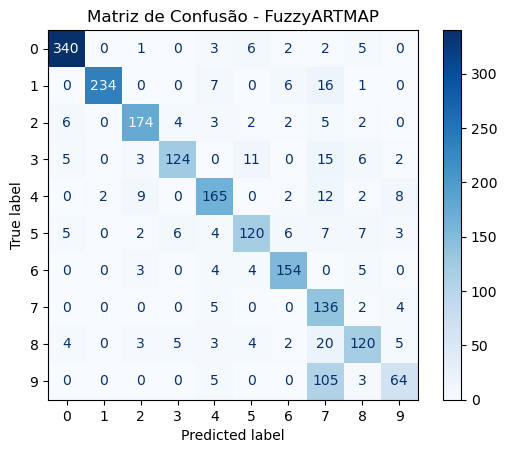

In [46]:
report = classification_report(y_test, fuzzy_artmap_predictions)
matrix = confusion_matrix(y_test, fuzzy_artmap_predictions)

print("\nClassification report:")
print(report)

cm = confusion_matrix(y_test, fuzzy_artmap_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - FuzzyARTMAP")
plt.show()

Confundiu muito 7 e 9

In [47]:
acc_matrix = generate_acc_matrix_fuzzyARTMAP(num_tasks, X_train_sorted, y_train_sorted, 
                                            X_test_sorted, y_test_sorted, 1)

acc_matrix

#print(f"Forward transfer {forward_transfer(num_tasks, acc_matrix)}")
#print(f"Backward transfer {backward_transfer(num_tasks, acc_matrix)}")
#print(f"Average Accuracy {average_accuracy(num_tasks, acc_matrix)}")



TypeError: FuzzyARTMAP.fit() missing 1 required positional argument: 'y'